Neccessary installs for this project:

In [ ]:
!pip install tweepy
!pip3 install cryptocompare
!pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import tweepy 
import cryptocompare
from textblob import TextBlob
import re
from wordcloud import WordCloud
from sklearn import (model_selection, linear_model, metrics)
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import qeds
qeds.themes.mpl_style();

# Introduction 

Utilizing tweets from Twitter, this paper explores the interaction between Bitcoin sentiment and Bitcoin prices via a classification analysis. 

# Twitter and Bitcoin Data

## Scraping Data 

### Scraping Relevant Bitcoin Tweets

The tweets were scraped using Twitter's stadard 7-day search API. 

The cells below (up to saving the dataframe) have already been exucted
but are displayed for completeness.  

In [ ]:
# keys and tokens removed for confidentiality 

consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [ ]:
text_query = "#bitcoin OR bitcoin -filter:retweets" 
count = 200_000 # estimated to provide a weeks worth of tweets matching this query 

try:
 # Creation of query method using parameters
 tweets = tweepy.Cursor(api.search,q=text_query,lang="en").items(count)
 
 # Pulling information from tweets iterable object
 tweets_list = [[tweet.created_at, tweet.user.name, tweet.user.screen_name, 
                 tweet.text, tweet.user.followers_count] for tweet in tweets]
 
 # Creation of dataframe from tweets list
 tweets_df = pd.DataFrame(tweets_list, columns = ['Tweet Datetime', 'name', 'Twitter @ name', 
                                                  'Tweet', 'Follower Count'])
 
except BaseException as e: 
    print('failed on_status,',str(e))
    time.sleep(3)

In [ ]:
# saving dataframe as a csv file
path = 'C:\\Econ 323\\TwitterData.csv'
tweets_df.to_csv(path, index=False)

In [2]:
# reading dataframe from saved csv file
t_df = pd.read_csv('TwitterData.csv', parse_dates=["Tweet Datetime"]) 

In [3]:
t_df.set_index("Tweet Datetime", inplace=True)
t_df.index

DatetimeIndex(['2020-12-19 11:15:37', '2020-12-19 11:15:37',
               '2020-12-19 11:15:35', '2020-12-19 11:15:32',
               '2020-12-19 11:15:29', '2020-12-19 11:15:28',
               '2020-12-19 11:15:28', '2020-12-19 11:15:26',
               '2020-12-19 11:15:24', '2020-12-19 11:15:23',
               ...
               '2020-12-16 13:43:06', '2020-12-16 13:43:05',
               '2020-12-16 13:43:05', '2020-12-16 13:43:05',
               '2020-12-16 13:43:04', '2020-12-16 13:43:04',
               '2020-12-16 13:43:04', '2020-12-16 13:43:03',
               '2020-12-16 13:43:03', '2020-12-16 13:43:03'],
              dtype='datetime64[ns]', name='Tweet Datetime', length=200000, freq=None)

In [4]:
t_df.info()
t_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200000 entries, 2020-12-19 11:15:37 to 2020-12-16 13:43:03
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            199993 non-null  object
 1   Twitter @ name  200000 non-null  object
 2   Tweet           200000 non-null  object
 3   Follower Count  200000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 7.6+ MB


,name,Twitter @ name,Tweet,Follower Count
Tweet Datetime,,,,
2020-12-19 11:15:37,Coinpedia - Fintech News,CoinpediaNews,@TheMoonCarl Now we have a common wish there.😇...,2685
2020-12-19 11:15:37,CryptoQueen.pl,CryptoqueenP,According to Mayer Multiply its still too earl...,1133
2020-12-19 11:15:35,Sandra Davis,SandraDavis01,"@v4mpgrI Just received a loan of $50,000 worth...",20
2020-12-19 11:15:32,TDB,tdbryan1987,@laxr2020 @saxena_puru She was laughed at for ...,689
2020-12-19 11:15:29,Bavesh Magan,MaganBavesh,#AAVE Breaking Medium line. Can it hold? #Bitc...,5
...,...,...,...,...
2020-12-16 13:43:04,J62 🔴🔴🔴🔴🔴🔴 ₿🚀🌙,interbiznw,Boiz.. We just BROKEEEEEEEEEEEE 20K #Bitcoin 🚀...,509
2020-12-16 13:43:04,Christian,chrispr79,We just hit 20k.! Whats is next?\n#Bitcoin,86
2020-12-16 13:43:03,A Rudd,AriRudd,"O wow 20,0000 #Bitcoin",319


### Scrapping Key Bitcoin Metrics

The Bitcoin metrics were scraped using the CryptoCompare API.

The cells below (up to saving the dataframe) have already been exucted
but are displayed for completeness. 

In [ ]:
# note: max limit is 2000
f = cryptocompare.get_historical_price_minute('BTC', 'EUR', limit=2000, exchange='CCCAGG', 
                                              toTs=dt.datetime.now())
bitcoin_df = pd.DataFrame(f)

In [ ]:
# saving dataframe as a csv file
path = 'C:\\Econ 323\\BitcoinData.csv'
bitcoin_df.to_csv(path, index=False)

In [5]:
# reading dataframe from saved csv file
path = 'C:\\Econ 323\\BitcoinData.csv'
b_df = pd.read_csv(path, parse_dates=["time"]) 

In [6]:
b_df.set_index("time", inplace=True)
b_df.info()
b_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2020-12-18 02:35:00 to 2020-12-19 11:55:00
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   high              2001 non-null   float64
 1   low               2001 non-null   float64
 2   open              2001 non-null   float64
 3   volumefrom        2001 non-null   float64
 4   volumeto          2001 non-null   float64
 5   close             2001 non-null   float64
 6   conversionType    2001 non-null   object 
 7   conversionSymbol  13 non-null     object 
dtypes: float64(6), object(2)
memory usage: 140.7+ KB


,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-12-18 02:35:00,18937.57,18931.09,18932.04,2.006,38005.00,18937.00,direct,NaN
2020-12-18 02:36:00,18949.26,18937.00,18937.00,13.950,264446.47,18941.69,direct,NaN
2020-12-18 02:37:00,18941.69,18898.19,18941.69,10.750,203493.68,18898.25,direct,NaN
2020-12-18 02:38:00,18911.28,18897.02,18898.25,3.184,60152.75,18911.28,direct,NaN
2020-12-18 02:39:00,18903.05,18896.66,18903.37,64.820,1225065.77,18899.50,invert_divide,ETH
...,...,...,...,...,...,...,...,...
2020-12-19 11:51:00,18713.63,18698.01,18698.01,2.955,55302.19,18712.78,direct,NaN
2020-12-19 11:52:00,18717.61,18709.04,18712.78,1.694,31725.34,18709.25,direct,NaN
2020-12-19 11:53:00,18715.55,18709.25,18709.25,3.718,69624.41,18714.26,direct,NaN


## Cleaning Twitter and Bitcoin Data

The tweet data and Bitcoin data must be consistent with each other in order to analyze Bitcoin metrics alongside their corresponding tweets. Thus, cleaning the tweet and Bitcoin dataframes is needed.

### Cleaning Twitter Data

In [7]:
# The Tweet Datetime column is made timezone-aware  

t_df.index = t_df.index.tz_localize('UCT')    
t_df.index

DatetimeIndex(['2020-12-19 11:15:37+00:00', '2020-12-19 11:15:37+00:00',
               '2020-12-19 11:15:35+00:00', '2020-12-19 11:15:32+00:00',
               '2020-12-19 11:15:29+00:00', '2020-12-19 11:15:28+00:00',
               '2020-12-19 11:15:28+00:00', '2020-12-19 11:15:26+00:00',
               '2020-12-19 11:15:24+00:00', '2020-12-19 11:15:23+00:00',
               ...
               '2020-12-16 13:43:06+00:00', '2020-12-16 13:43:05+00:00',
               '2020-12-16 13:43:05+00:00', '2020-12-16 13:43:05+00:00',
               '2020-12-16 13:43:04+00:00', '2020-12-16 13:43:04+00:00',
               '2020-12-16 13:43:04+00:00', '2020-12-16 13:43:03+00:00',
               '2020-12-16 13:43:03+00:00', '2020-12-16 13:43:03+00:00'],
              dtype='datetime64[ns, UCT]', name='Tweet Datetime', length=200000, freq=None)

In [8]:
# Now the Tweet Datetime column can be converted to Pacific Standard Time 

t_df.index = t_df.index.tz_convert('America/Los_Angeles')
t_df.index

DatetimeIndex(['2020-12-19 03:15:37-08:00', '2020-12-19 03:15:37-08:00',
               '2020-12-19 03:15:35-08:00', '2020-12-19 03:15:32-08:00',
               '2020-12-19 03:15:29-08:00', '2020-12-19 03:15:28-08:00',
               '2020-12-19 03:15:28-08:00', '2020-12-19 03:15:26-08:00',
               '2020-12-19 03:15:24-08:00', '2020-12-19 03:15:23-08:00',
               ...
               '2020-12-16 05:43:06-08:00', '2020-12-16 05:43:05-08:00',
               '2020-12-16 05:43:05-08:00', '2020-12-16 05:43:05-08:00',
               '2020-12-16 05:43:04-08:00', '2020-12-16 05:43:04-08:00',
               '2020-12-16 05:43:04-08:00', '2020-12-16 05:43:03-08:00',
               '2020-12-16 05:43:03-08:00', '2020-12-16 05:43:03-08:00'],
              dtype='datetime64[ns, America/Los_Angeles]', name='Tweet Datetime', length=200000, freq=None)

In [9]:
# Tweet Datetime is rounded to minutes only

t_df.index = t_df.index.floor('Min')

In [10]:
# Sorting Tweet Datetime column by ascending order 

t_df.sort_values(by='Tweet Datetime',ascending=True, inplace=True)
t_df

,name,Twitter @ name,Tweet,Follower Count
Tweet Datetime,,,,
2020-12-16 05:43:00-08:00,Pablo Lerdo 🪁,PabloLerdoNews,"#Bitcoin just broke the 20,000 !",105
2020-12-16 05:43:00-08:00,Peter Andersson,PeterPeterand88,#bitcoin just took the magic 20$k! https://t.c...,423
2020-12-16 05:43:00-08:00,John Bednarski,john_bednarski,#Bitcoin hits 2 week high breaking last big re...,346
2020-12-16 05:43:00-08:00,Whit GaŁŁimore🔗,WhitGallimore,#bitcoin breaks $20K for the first time!!,580
2020-12-16 05:43:00-08:00,David 🥸,dvdutch2,#Bitcoin finally broke $20k 😩,609
...,...,...,...,...
2020-12-19 03:15:00-08:00,nii bitcoin,bitcoinn7,Free #Bitcoin instantly. I have recover all my...,83
2020-12-19 03:15:00-08:00,Crypto Revolution Merchandise,CryptoRevolut16,@TheMoonCarl All I want for #Christmas is 10 m...,363
2020-12-19 03:15:00-08:00,Big Blockers,big_blockers,The current price of Bitcoin is $23036.00.\nTh...,3059


In [11]:
# extracting only tweets that correspond to the Bitcoin dataframe

t_df = t_df.loc["2020-12-18 02:36:00":"2020-12-19 03:15:00"]
t_df

,name,Twitter @ name,Tweet,Follower Count
Tweet Datetime,,,,
2020-12-18 02:36:00-08:00,꧁Marin꧂,pick_corn,$btc #btc #bitcoin $eth $bnb $cover $ppt $vidt...,1036
2020-12-18 02:36:00-08:00,Feras_Y,FeraSY1,#Bitcoin\nImagine that $Btc can crash 3000$ do...,20720
2020-12-18 02:36:00-08:00,𝒯𝒽𝒾𝓃𝑒 𝔾 🌞,Desthin21,"@bitwala Bitcoin operates universally, meaning...",2108
2020-12-18 02:36:00-08:00,Mac,MindsetBitcoin,Who you follow on Twitter can change your life...,30
2020-12-18 02:36:00-08:00,TRON AGE,tron_age,I'm not buying Bitcoin! I'm investing in UK sh...,7237
...,...,...,...,...
2020-12-19 03:15:00-08:00,nii bitcoin,bitcoinn7,Free #Bitcoin instantly. I have recover all my...,83
2020-12-19 03:15:00-08:00,Crypto Revolution Merchandise,CryptoRevolut16,@TheMoonCarl All I want for #Christmas is 10 m...,363
2020-12-19 03:15:00-08:00,Big Blockers,big_blockers,The current price of Bitcoin is $23036.00.\nTh...,3059


In [12]:
# extract only the relevant columns

t_df.drop(['name','Twitter @ name', 'Follower Count'], 1, inplace=True)
t_df

C:\Users\kiano\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Tweet
Tweet Datetime,
2020-12-18 02:36:00-08:00,$btc #btc #bitcoin $eth $bnb $cover $ppt $vidt...
2020-12-18 02:36:00-08:00,#Bitcoin\nImagine that $Btc can crash 3000$ do...
2020-12-18 02:36:00-08:00,"@bitwala Bitcoin operates universally, meaning..."
2020-12-18 02:36:00-08:00,Who you follow on Twitter can change your life...
2020-12-18 02:36:00-08:00,I'm not buying Bitcoin! I'm investing in UK sh...
...,...
2020-12-19 03:15:00-08:00,Free #Bitcoin instantly. I have recover all my...
2020-12-19 03:15:00-08:00,@TheMoonCarl All I want for #Christmas is 10 m...
2020-12-19 03:15:00-08:00,The current price of Bitcoin is $23036.00.\nTh...


A big part of natural langauge processing is cleaning the text. Unnecessary characters or punctuation hinder the computer's ability to assign a sentiment. 

In [13]:
def cleanTxt(text):
    """ 
    function to clean the tweets 
    """
    text = re.sub(r'@[a-zA-Z0-9]+', '', text) # removes @mention
    text = re.sub(r'#', '', text) # removes '#' symbol 
    text = re.sub(r'https?:\/\/\S+', '', text) # removes hyperlink
    text = re.sub(r'[^\w\s]', '', text) #removes punctuation
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", '', text) # removes numbers
    text = text.lower() # converts text to lowercase 
    return text

In [14]:
# cleaning the tweets

t_df['Tweet'] = t_df['Tweet'].apply(cleanTxt)
t_df

<ipython-input-14-6039cfbfb5b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['Tweet'] = t_df['Tweet'].apply(cleanTxt)


,Tweet
Tweet Datetime,
2020-12-18 02:36:00-08:00,btc btc bitcoin eth bnb cover ppt vidt link arp
2020-12-18 02:36:00-08:00,bitcoin\nimagine that btc can crashdown and st...
2020-12-18 02:36:00-08:00,bitcoin operates universally meaning for the ...
2020-12-18 02:36:00-08:00,who you follow on twitter can change your life...
2020-12-18 02:36:00-08:00,im not buying bitcoin im investing in uk share...
...,...
2020-12-19 03:15:00-08:00,free bitcoin instantly i have recover all my s...
2020-12-19 03:15:00-08:00,all i want for christmas ismore bitcoin pleee...
2020-12-19 03:15:00-08:00,the current price of bitcoin isthe current pri...


Below a word cloud is used to visualize the tweets.

<function matplotlib.pyplot.show(*args, **kw)>

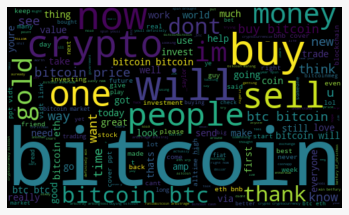

In [15]:
allWords = ''.join([twts for twts in t_df['Tweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show

### Cleaning Bitcoin Data

In [16]:
# As done with the twitter dataframe, 
# the Bitcoin dataframe is also converted to Pacific Standard Time: 

b_df.index = b_df.index.tz_localize('America/Los_Angeles')    
b_df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-12-18 02:35:00-08:00,18937.57,18931.09,18932.04,2.006,38005.00,18937.00,direct,NaN
2020-12-18 02:36:00-08:00,18949.26,18937.00,18937.00,13.950,264446.47,18941.69,direct,NaN
2020-12-18 02:37:00-08:00,18941.69,18898.19,18941.69,10.750,203493.68,18898.25,direct,NaN
2020-12-18 02:38:00-08:00,18911.28,18897.02,18898.25,3.184,60152.75,18911.28,direct,NaN
2020-12-18 02:39:00-08:00,18903.05,18896.66,18903.37,64.820,1225065.77,18899.50,invert_divide,ETH
...,...,...,...,...,...,...,...,...
2020-12-19 11:51:00-08:00,18713.63,18698.01,18698.01,2.955,55302.19,18712.78,direct,NaN
2020-12-19 11:52:00-08:00,18717.61,18709.04,18712.78,1.694,31725.34,18709.25,direct,NaN
2020-12-19 11:53:00-08:00,18715.55,18709.25,18709.25,3.718,69624.41,18714.26,direct,NaN


In [17]:
# similary only the metrics that correspond to tweet times are extracted

b_df = b_df.loc["2020-12-18 02:36:00":"2020-12-19 03:15:00"]
b_df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-12-18 02:36:00-08:00,18949.26,18937.00,18937.00,13.950,264446.47,18941.69,direct,NaN
2020-12-18 02:37:00-08:00,18941.69,18898.19,18941.69,10.750,203493.68,18898.25,direct,NaN
2020-12-18 02:38:00-08:00,18911.28,18897.02,18898.25,3.184,60152.75,18911.28,direct,NaN
2020-12-18 02:39:00-08:00,18903.05,18896.66,18903.37,64.820,1225065.77,18899.50,invert_divide,ETH
2020-12-18 02:40:00-08:00,18914.66,18897.75,18912.70,2.594,49064.10,18897.75,direct,NaN
...,...,...,...,...,...,...,...,...
2020-12-19 03:11:00-08:00,18903.71,18897.22,18897.22,2.568,48528.43,18901.25,direct,NaN
2020-12-19 03:12:00-08:00,18907.36,18901.25,18901.25,8.306,156973.64,18905.73,direct,NaN
2020-12-19 03:13:00-08:00,18911.59,18905.00,18905.73,6.503,122942.49,18909.43,direct,NaN


In order to avoid bias, a lag must be incorporated. I will assume a $1$ minute lag between tweet and close price. Namely, we will study the interaction between a tweet at minute $n$ and the corresponding 
Bitcoin close price at minute $n+1$.

In [18]:
lag = 1 

b_df['Lag Price'] = b_df["close"].shift(-lag)
b_df

<ipython-input-18-237acb3bc6e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_df['Lag Price'] = b_df["close"].shift(-lag)


,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,Lag Price
time,,,,,,,,,
2020-12-18 02:36:00-08:00,18949.26,18937.00,18937.00,13.950,264446.47,18941.69,direct,NaN,18898.25
2020-12-18 02:37:00-08:00,18941.69,18898.19,18941.69,10.750,203493.68,18898.25,direct,NaN,18911.28
2020-12-18 02:38:00-08:00,18911.28,18897.02,18898.25,3.184,60152.75,18911.28,direct,NaN,18899.50
2020-12-18 02:39:00-08:00,18903.05,18896.66,18903.37,64.820,1225065.77,18899.50,invert_divide,ETH,18897.75
2020-12-18 02:40:00-08:00,18914.66,18897.75,18912.70,2.594,49064.10,18897.75,direct,NaN,18872.80
...,...,...,...,...,...,...,...,...,...
2020-12-19 03:11:00-08:00,18903.71,18897.22,18897.22,2.568,48528.43,18901.25,direct,NaN,18905.73
2020-12-19 03:12:00-08:00,18907.36,18901.25,18901.25,8.306,156973.64,18905.73,direct,NaN,18909.43
2020-12-19 03:13:00-08:00,18911.59,18905.00,18905.73,6.503,122942.49,18909.43,direct,NaN,18916.85


In [19]:
# only extracting relevant columns 

b_df.drop(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close', 'conversionType', 'conversionSymbol'],
           1, inplace=True)
b_df

C:\Users\kiano\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Lag Price
time,
2020-12-18 02:36:00-08:00,18898.25
2020-12-18 02:37:00-08:00,18911.28
2020-12-18 02:38:00-08:00,18899.50
2020-12-18 02:39:00-08:00,18897.75
2020-12-18 02:40:00-08:00,18872.80
...,...
2020-12-19 03:11:00-08:00,18905.73
2020-12-19 03:12:00-08:00,18909.43
2020-12-19 03:13:00-08:00,18916.85


In [20]:
# computing the percentage change in close from one minute to the next 

b_df['Lag Price'] = b_df['Lag Price'].pct_change(1)
b_df

<ipython-input-20-2e35ad8787d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_df['Lag Price'] = b_df['Lag Price'].pct_change(1)


,Lag Price
time,
2020-12-18 02:36:00-08:00,NaN
2020-12-18 02:37:00-08:00,0.000689
2020-12-18 02:38:00-08:00,-0.000623
2020-12-18 02:39:00-08:00,-0.000093
2020-12-18 02:40:00-08:00,-0.001320
...,...
2020-12-19 03:11:00-08:00,0.000237
2020-12-19 03:12:00-08:00,0.000196
2020-12-19 03:13:00-08:00,0.000392


In [21]:
# making Lag Price column true when its percantage change is positve, and false otherwise 

b_df['Lag Price'] = b_df['Lag Price']>0
b_df['Lag Price'] = b_df['Lag Price'].astype(int)  # 0,1 instead of False,True
b_df  

<ipython-input-21-ce0c69c1562e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_df['Lag Price'] = b_df['Lag Price']>0
<ipython-input-21-ce0c69c1562e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_df['Lag Price'] = b_df['Lag Price'].astype(int)  # 0,1 instead of False,True


,Lag Price
time,
2020-12-18 02:36:00-08:00,0
2020-12-18 02:37:00-08:00,1
2020-12-18 02:38:00-08:00,0
2020-12-18 02:39:00-08:00,0
2020-12-18 02:40:00-08:00,0
...,...
2020-12-19 03:11:00-08:00,1
2020-12-19 03:12:00-08:00,1
2020-12-19 03:13:00-08:00,1


# Sentiment Analysis

## Incorporating Subjectivity and Polarity 

Using the textblob library, we can find two different measures of sentiment; subjectivity and polarity. Polarity is some real number $p\in[-1,1]$, where $p=1$ implies positive sentiment and $p=-1$ implies negative sentiment. Subjectivity is some real number $s\in[0,1]$ and it can be thought as a generalization of polarity.

In [22]:
# subjectivity function 
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# polarity function 
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [23]:
# creating new Subjectivity and Polarity columns

t_df['Subjectivity'] = t_df['Tweet'].apply(getSubjectivity)
t_df['Polarity'] = t_df['Tweet'].apply(getPolarity)

t_df

<ipython-input-23-651cec35cc06>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['Subjectivity'] = t_df['Tweet'].apply(getSubjectivity)
<ipython-input-23-651cec35cc06>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['Polarity'] = t_df['Tweet'].apply(getPolarity)


,Tweet,Subjectivity,Polarity
Tweet Datetime,,,
2020-12-18 02:36:00-08:00,btc btc bitcoin eth bnb cover ppt vidt link arp,0.000000,0.000000
2020-12-18 02:36:00-08:00,bitcoin\nimagine that btc can crashdown and st...,0.277273,0.068182
2020-12-18 02:36:00-08:00,bitcoin operates universally meaning for the ...,0.111111,0.083333
2020-12-18 02:36:00-08:00,who you follow on twitter can change your life...,0.000000,0.000000
2020-12-18 02:36:00-08:00,im not buying bitcoin im investing in uk share...,0.000000,0.000000
...,...,...,...
2020-12-19 03:15:00-08:00,free bitcoin instantly i have recover all my s...,0.733333,0.200000
2020-12-19 03:15:00-08:00,all i want for christmas ismore bitcoin pleee...,0.000000,0.000000
2020-12-19 03:15:00-08:00,the current price of bitcoin isthe current pri...,0.400000,0.000000


## Visualizing Subjectivity and Polarity 

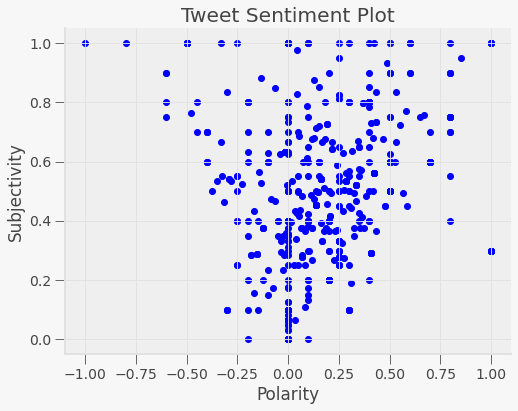

In [24]:
# plotting the polarity and subjectivity of the first 1000 tweets

plt.figure(figsize=(8,6))
for i in range(0,1000):  # instead of for i in range(0,t_df.shape[0]):
    plt.scatter(t_df['Polarity'][i], t_df['Subjectivity'][i], color='Blue')
    
plt.title('Tweet Sentiment Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

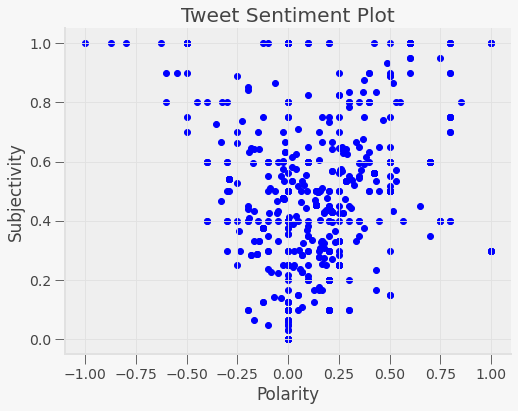

In [25]:
# plotting the polarity and subjectivity of the last 1000 tweets
plt.figure(figsize=(8,6))
for i in range(t_df.shape[0]-1000,t_df.shape[0]):  # instead of for i in range(0,t_df.shape[0]):
    plt.scatter(t_df['Polarity'][i], t_df['Subjectivity'][i], color='Blue')
    
plt.title('Tweet Sentiment Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

From the two graphs we can observe that mean subjectivity is about 0.3 and mean polarity is about 0. 

# Classification Model 

It is now possible to begin a classification analysis since the target (change in Bitcoin price) takes on discrete values (1 if change is positive, 0 otherwise) . In this section, I will explore the logistic regression, decission tree and random forest algorithms.

In [26]:
# Explanatory variable X is mean sentiment, 
# the two candidates are mean subjectivity and mean polarity 

X_1 = t_df.groupby('Tweet Datetime').Subjectivity.mean() 
X_2 = t_df.groupby('Tweet Datetime').Polarity.mean()

# Dependent variable y is the change in Bitcoin Lag Price 
y = b_df['Lag Price']

Below we can see that subjectivity and polarity are relatively steady with respect to the given time frame.

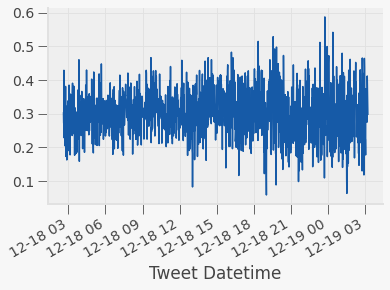

In [27]:
X_1.plot()

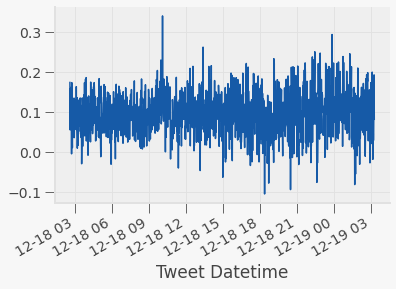

In [28]:
X_2.plot()

In [29]:
# splitting the data into 75% train, 25% test

X_1_train, X_1_test, y_train, y_test = model_selection.train_test_split(X_1, y, test_size=0.25)

X_2_train, X_2_test, y_train, y_test = model_selection.train_test_split(X_2, y, test_size=0.25)

In [30]:
# converting the features from series to dataframe

X_1_train = pd.DataFrame(X_1_train)
X_1_test = pd.DataFrame(X_1_test)


X_2_train = pd.DataFrame(X_2_train)
X_2_test = pd.DataFrame(X_2_test)

In [31]:
# coverting the features to a 2D array by adding a column 

X_1_train = X_1_train.values.reshape(-1, 1) 
X_1_test = X_1_test.values.reshape(-1, 1)

X_2_train = X_2_train.values.reshape(-1, 1) 
X_2_test = X_2_test.values.reshape(-1, 1)

## Logistic Regression

### Single Feature: Mean Subjectivity

In [32]:
logistic_model_s = linear_model.LogisticRegression(solver='lbfgs')
logistic_model_s.fit(X_1_train, y_train)

beta_0_s = logistic_model_s.intercept_[0]
beta_1_s = logistic_model_s.coef_[0][0]

print(f"Fit model: p(lag price) = L({beta_0_s:.4f} + {beta_1_s:.4f} mean subjectivity)")

Fit model: p(lag price) = L(-0.0532 + 0.3441 mean subjectivity)


### Single Feature: Mean Polarity

In [33]:
logistic_model_p = linear_model.LogisticRegression(solver='lbfgs')
logistic_model_p.fit(X_2_train, y_train)

beta_0_p = logistic_model_p.intercept_[0]
beta_1_p = logistic_model_p.coef_[0][0]  

print(f"Fit model: p(lag price) = L({beta_0_p:.4f} + {beta_1_p:.4f} mean polarity)")

Fit model: p(lag price) = L(0.0016 + 0.5094 mean polarity)


### Two Features: Subjectivity and Polarity

In [34]:
# splitting the data into 75% train, 25% test 

X = pd.concat([X_1, X_2], axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [35]:
logistic_sp_model = linear_model.LogisticRegression(solver='lbfgs')
logistic_sp_model.fit(X_train, y_train)

beta_0_sp = logistic_sp_model.intercept_[0]
beta_1_sp , beta_2_sp = logistic_sp_model.coef_[0]

print(f"""Fit model: p(lag price) = L({beta_0_sp:.4f} + {beta_1_sp:.4f} subjectivity +
      {beta_2_sp:.4f} polarity)""")

Fit model: p(lag price) = L(-0.0219 + 0.1947 subjectivity +
      0.5291 polarity)


## Model Evaluation

### Accuracy 

In [36]:
# for subjectivity:
train_acc_s = logistic_model_s.score(X_1_train, y_train)
test_acc_s = logistic_model_s.score(X_1_test, y_test)

print(f"Train accuracy: {train_acc_s}, Test accuracy: {test_acc_s}")

Train accuracy: 0.5162162162162162, Test accuracy: 0.5405405405405406


In [37]:
# for polarity:
train_acc_p = logistic_model_p.score(X_2_train, y_train)
test_acc_p = logistic_model_p.score(X_2_test, y_test)

print(f"Train accuracy: {train_acc_p}, Test accuracy: {test_acc_p}")

Train accuracy: 0.5126126126126126, Test accuracy: 0.5351351351351351


In [38]:
# for both subjectivity and polarity:
train_acc_sp = logistic_sp_model.score(X_train, y_train)
test_acc_sp = logistic_sp_model.score(X_test, y_test)

print(f"Train accuracy: {train_acc_sp}, Test accuracy: {test_acc_sp}")

Train accuracy: 0.5234234234234234, Test accuracy: 0.5351351351351351


## Decision Tree 

In [39]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)

dt_train_acc = dt_model.score(X_train, y_train)
dt_test_acc = dt_model.score(X_test, y_test)

print(f"Training accuracy: {dt_train_acc}, Testing accuracy: {dt_test_acc}")

Training accuracy: 1.0, Testing accuracy: 0.527027027027027


## Random Forest

In [40]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_train_acc = rf_model.score(X_train, y_train)
rf_test_acc = rf_model.score(X_test, y_test)

print(f"Training accuracy: {rf_train_acc}, Testing accuracy: {rf_test_acc}")

Training accuracy: 1.0, Testing accuracy: 0.5297297297297298


# Conclusion

For the logistic regression model the flip coin accuracy for the train data, in comparison to the slightly higher accuracies for the test data sugggest that this model lacks predictive power. While the decision tree and randforest models highlight that overfitting is taking place as the model perfectly learns the training data but fails to do better than flip coin accuracy for the test data.

The highly volatile nature of Bitcoin prices versus the more steady nature of sentiment shown by the data suggest that it is likely better to study hourly or daily metrics.